<a href="https://colab.research.google.com/github/Camillabgarcia/Apache_Spark_com_Python/blob/main/Spark_processamento_de_linguagem_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.0 Introdução
### **1.1 Sessão e leitura dos dados**

Instalando o PySpark

In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Iniciando uma sessão

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [ ]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/drive/MyDrive/Spark_processamento_de_linguagem_natural/imdb-reviews-pt-br.csv.crdownload",
                       escape="\"",
                       header=True,
                       inferSchema=True)

### **1.2 Explorando os dados**

Explorando os dados bucando entender:
- O tamanho dos dados (quantidade de linhas e colunas).
- Os campos e tipo.
- O conteúdo em cada campo.
- A proporção das categorias.

O tamanho dos dados:



In [ ]:
print(f'Número de linhas: {dados.count()}', f'Número de colunas: {len(dados.columns)}')

Número de linhas: 48751 Número de colunas: 4


Campos e tipo:

In [ ]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



Conteúdo da base de dados:

In [ ]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



Apresentando alguns comentários ditos como negativo ou positivo:

In [ ]:
print('Comentário Negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)
print('Comentário Positivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

Comentário Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                      

Contabilizando os tipodes de comentários positivos/negativos:

In [ ]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|23985|
|      neg|24765|
|     NULL|    1|
+---------+-----+



**2.0 Limpeza e Processamento**

2.1 Processo e bibliotecas

Iniciaremos nosso projeto criando uma nuvem de palavras que nos ajudará a perceber quais termos mais se repetem e quais podem ser removidos no processamento de dados. Importando as bibliotecas necessárias:

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Coletando uma amostra dos nossos depoimentos para otimizar o processamento do Spark:

In [ ]:
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

Construindo o word cloud:

In [ ]:
wordcloud = WordCloud(background_color= 'white',
                      width = 1000,
                      height= 600,
                      collocations=False,
                      prefer_horizontal=1).generate(str(tudo))

Visualizando o WordCloud:

 Identificamos a presença de várias preposições como "não", "que" e "para", além de outros termos que não agregam muito sentido à nossa análise. Esta observação nos leva à conclusão que nosso conjunto de dados precisa passar por alguns processos de remoção de palavras.

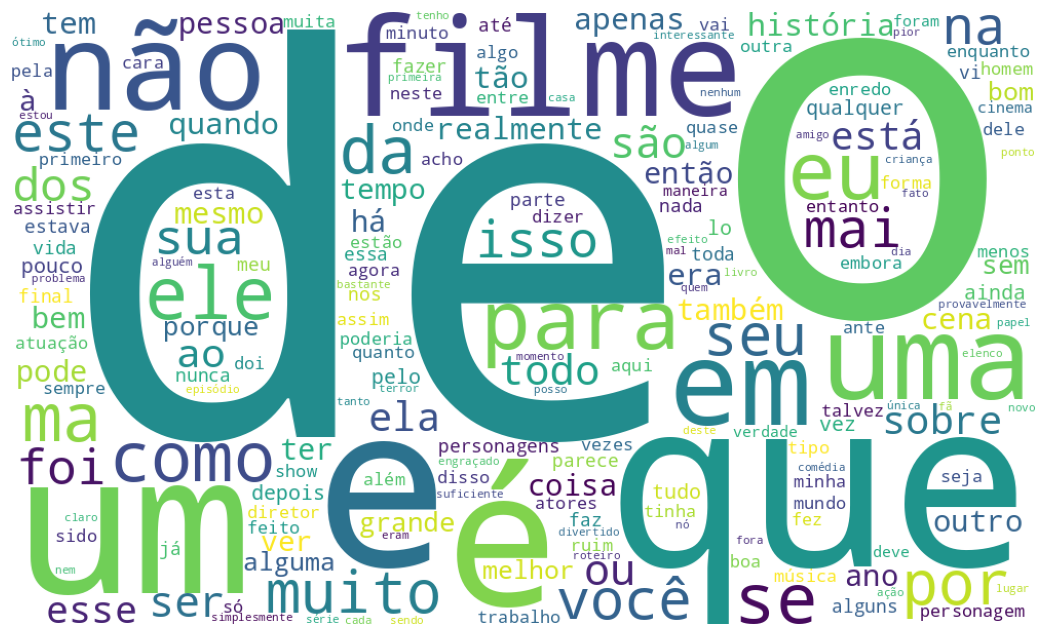

In [ ]:
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

2.1 Limpeza: caractere especiais:

Caracteres de pontuação comuns:

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Exemplo de dataframe para a limpeza:

In [ ]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

Importando a função Regex:

In [ ]:
import pyspark.sql.functions as f

Iniciando o código de limpeza:

In [ ]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

Visualizando o dataframe limpo:

In [ ]:
amostra.show(truncate=False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



Retirando os espaços em branco no exemplo:

In [ ]:
amostra = amostra.withColumn('texto_limpo', f.trim(amostra.texto_regex))
amostra.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

Retirando os caracteres especiais dos dados reais:

In [ ]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Retirando os espaços em branco do começo e do final de cada frase:

In [ ]:
dados = dados.withColumn('texto_limpo', f.trim(dados.texto_regex))
dados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



2.3 Tokenização: divisão em tokens

Importando a função Tokenizer e criando um objeto onde constam os comentários onde aplicamos, anteriormente, Regex e Trim na coluna de entrada e constarãos os tokens criados a partir dos depoimentos na coluna de saída:

In [ ]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)
tokenizado.select('texto_limpo', 'tokens').show(10)

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
+--------------------+--------------------+
only showing top 10 rows



Contando quantos tokens os comentários foram divididos:

Obs: Devido a grande quantidade de tokens, será necessário diminuir o número para ajudar no processamento e na classificação dos comentários positivos/negativos.

In [ ]:
from pyspark.sql.types import IntegerType
countTokens = f.udf(lambda tokens : len(tokens), IntegerType())
tokenizado.select('texto_limpo', 'tokens')\
          .withColumn('freq_tokens', countTokens(f.col('tokens'))).show(10)

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
+--------------------+--------------------+-----------+
only showing top 10 rows



2.4 StopWords: remoção de ruídos

Começando com um exemplo pequeno para depois aplicar em nossos dados:

In [ ]:
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

Explorando a biblioteca nltk e da classe stopwords:

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_A = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Explorando a biblioteca pyspark:

In [ ]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords('portuguese')

Comparando os diferentes stopwords na base dados exemplo, mas primeiramente é necessário fazer a tokenização:

In [ ]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol= "tokens")
tokenized = tokenizer.transform(df)

Definindo o remover e transformando a base de dados de exemplo com stop_A:

Obs: Ao executar, perceba que temos 3 colunas: na primeira, há a amostra original; na segunda, os tokens; e na terceira, os tokens com as stop words removidas. Podemos notar que palavras como "é", "não" e "do" foram removidas a partir da coleção do NLTK.

In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords=stop_A)
df = remover.transform(tokenized)
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



Fazendo o mesmo procedimento para o conjunto de palavras do PySpark que definimos como stop_B:

In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_B)
df = remover.transform(tokenized)
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



Retirando os stopwords dos depoimentos do nosso projeto:

In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")
feature_data = remover.transform(tokenizado)
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

Contagem de tokens antes e depois do stopwords:

In [ ]:
feature_data.select("tokens", "texto_final")\
                    .withColumn("freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|freq_tokens|fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

3.0 Vetorização das palavras

3.1 Bag of words

Contabilizando as palavras:

In [ ]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")
model = cv.fit(df)
df = model.transform(df)

Visualizando os dados:

In [ ]:
df.select('texto_final', 'CountVec').show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



Descobrindo a ordem das palavras:

In [ ]:
model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

Aplicando o bag of words no projeto:

In [ ]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")

model = cv.fit(feature_data)

countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()#truncate=False

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(214628,[0,7,8,11...|
|[example, majorit...|(214628,[1,2,3,8,...|
|[first, hate, mor...|(214628,[0,2,4,11...|
|[even, beatles, w...|(214628,[0,1,2,4,...|
|[brass, pictures,...|(214628,[1,3,5,8,...|
+--------------------+--------------------+



Descobrindo a ordem das palavras:

In [ ]:
model.vocabulary

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'bad',
 'great',
 'people',
 'also',
 'dont',
 'first',
 'movies',
 'made',
 'make',
 'films',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'acting',
 'never',
 'character',
 'love',
 'plot',
 'best',
 'little',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'say',
 'still',
 'end',
 'scene',
 'scenes',
 'man',
 'something',
 'go',
 'back',
 'im',
 'watching',
 'thing',
 'real',
 'actors',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'nothing',
 'find',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'cant',
 'part',
 'us',
 'want',
 'pretty',
 'director',
 'thats',
 'cast',
 'quite',
 'things',
 'got',
 'seems',
 'around',
 'young',
 'fact',
 'take',
 'horror',
 'enough',
 'thought',
 'give',
 'big',
 'world',
 'ive',
 'may',
 'saw',
 'however',
 'long',
 'isnt',
 'always',
 'with

3.2 Alternativa para o Countvector, Hashing TF, quer limita o número de palavras contabilizadas.

Importando a biblioteca:

In [ ]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

Visualizando o que foi feito:

In [ ]:
HTFfeaturizedData.select('texto_final', 'hashingTF').limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



3.3 TF-IDF: contabiliza e pondera as palavras

Importando a classe IDF através do comando:

In [ ]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

Visualizando o que foi feito na base de dados:

In [ ]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

3.4 Pipeline de Transformação


In [ ]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|23985|
|      neg|24765|
|     NULL|    1|
+---------+-----+



Convertendo os dados de texto em números com o stringindexer, com isso saberemos quantos comentários positvos e negativos existem:

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer

# Remover valores nulos na coluna 'sentiment'
dados = dados.filter(col("sentiment").isNotNull())

# Configurar o StringIndexer para pular valores nulos e definir uma nova coluna de saída
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label", handleInvalid="skip")

# Ajustar o modelo e transformar os dados
dados = stringindexer.fit(dados).transform(dados)

# Agrupar pela coluna 'sentiment' e 'label' e contar as ocorrências
dados.groupBy(['sentiment', 'label']).count().show()


+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|23985|
|      neg|  0.0|24765|
+---------+-----+-----+



Utilizando a função Pipeline a fim de unir todos os procedimentos em uma única célula. Para isso, precisamos importar esta função através do comando from pyspark.ml import Pipeline:

In [ ]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [ ]:
dados_trasnformados = pipeline.fit(dados).transform(dados)

Visualizndo os dados modificados:

In [ ]:
dados_trasnformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

4.0 Treinando o Modelo

Ajustaremos nossa árvore de decisão para que ela possa criar uma série de regras a fim classificar os depoimentos. Ao se deparar com um comentário, novas regras se formarão e servirão de base para a classificação deste comentário como positivo ou negativo

Selecionando as colunas de interesse:

In [ ]:
featureDF = dados_trasnformados.select(['features', 'label'])

Visualizando os dados:

In [ ]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Entendo a estrutura de cada coluna:

In [ ]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



Ajustando uma árvore de decisão no pipeline de transformação e ajuste:

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)



pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])

3.3 Amostra e Treino

Antes de aplicar a pipeline no conjunto de dados, é necessário separar os dados de treino e teste:

In [ ]:
treino, teste = dados.randomSplit([0.7, 0.3], seed=101)

Ajustando o modelo com a pipeline:

In [ ]:
dt_modelo = pipeline.fit(treino)

Aplicando na base de teste:

In [ ]:
previsao = dt_modelo.transform(teste)

Visualizando as previsões:

Obs: Vamos a algumas observações sobre as colunas "label" e "predictions":

- "label" diz respeito ao sentimento real, ou seja, à classificação original do comentário. Lembre-se que nossos dados vieram categorizados em positivos e negativos (pos e neg) e nós codificamos essa classificação.
- A coluna "predictions", por sua vez, indica a classificação desses comentários a partir do processo que realizamos. Note que há comentários classificados erroneamente como positivos.

In [ ]:
previsao.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|      [9.0,0.0]|           [1.0,0.0]|       0.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

5.0 Explicando os resultados

5.1 Teste e métricas de avaliação

Selecioando as classificações reais (label) e as classificações feita pelo modelo (prediction):

Obs: é notado que alguns comentários foram classificados diferentes da categorização original.

In [ ]:
previsao.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



Avaliando a classificação feita anteriormente, utilizando a classe MulticlassClassificationEvaluator:

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

acuracia = evaluator.evaluate(previsao)

Visualizando o resultado da métrica:

In [ ]:
print("Acuracia = %s" % acuracia)

Acuracia = 0.6719797509919277


5.2 Classificação para uma frase em específico

Usaremos a amostra a seguir, em que o primeiro comentário é negativo, e o segundo, positivo:

In [ ]:
nova_base = spark.createDataFrame([
    (1, "This is without doubt the worst movie I have ever seen, I hated the acting of the actor."),
    (0, "I loved the movie, excellent acting!"),
], ["id", "texto_limpo"])


Armazenaremos a transformação dessa base a partir da função pipeline que criamos anteriormente:

In [ ]:
nova_class = dt_modelo.transform(nova_base)

Entendo como foi a classificação:

Obs: Observe que ele aplicou a este dataframe todo o processo que vimos até agora e classificou o primeiro depoimento como negativo, e o segundo, como positivo. Sendo assim, o modelo conseguiu identificar corretamente os sentimentos destes comentários.

In [ ]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...| [635.0,85.0]|[0.88194444444444...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[219.0,757.0]|[0.22438524590163...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

